# 🚀 Customize and Deploy `Qwen/Qwen3-VL-2B-Instruct` on Amazon SageMaker AI

---

In this notebook, we explore **Qwen3-VL-2B-Instruct**, a ~2-billion-parameter vision-language instruction-tuned model from Alibaba’s Qwen3 “VL” series. You’ll learn how to fine-tune it with image + text instruction workflows, evaluate its vision-language output performance, and deploy it via SageMaker for multimodal assistant use-cases.

**What is Qwen3-VL-2B-Instruct?**
Qwen3-VL-2B-Instruct is the instruction-tuned vision-language variant of the Qwen3 family at ~2B parameters. The “VL” denotes support for both image and text input, while “Instruct” indicates that the model has been fine-tuned to follow human instructions. The Qwen3 family is released under the **Apache-2.0 license**.

---

**Key Specifications**

| Feature                   | Details                                                                               |
| ------------------------- | ------------------------------------------------------------------------------------- |
| **Parameters**            | ~2 billion                                                                            |
| **Modalities**            | Image + Text input → Text output                                                      |
| **Context / Window Size** | Large text context (e.g., tens of thousands of tokens) combined with vision input     |
| **Architecture**          | Dense Transformer backbone with vision encoder front-end and instruction-tuned output |
| **License**               | Apache-2.0                                                                            |

---

**Benchmarks & Behavior**

* The Qwen3-VL models demonstrate strong capabilities in vision-language reasoning, structured output generation, and instruction following.
* At ~2B size, Qwen3-VL-2B-Instruct offers an efficient footprint for multimodal tasks where modest compute is available.
* Ideal for tasks such as image-guided question answering, vision-augmented instruction following, and assistant workflows that take images + text prompts.

---

**Using This Notebook**

Here’s what you’ll cover:

* Load a sample image + instruction dataset from Hugging Face and prepare it for fine-tuning
* Fine-tune with SageMaker Training Jobs
* Run model evaluation (vision + instruction tasks)
* Deploy to SageMaker Endpoints

In [1]:
# %pip install -Uq sagemaker datasets

In [1]:
import boto3
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


In [2]:
region = boto3.Session().region_name

from sagemaker.local import LocalSession 
sess = LocalSession() #sagemaker.Session(boto3.Session(region_name=region))
sess.config = {"local": {"local_code": True}}

sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()

In [3]:
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::811828458885:role/Admin
sagemaker bucket: sagemaker-us-east-1-811828458885
sagemaker session region: us-east-1


## Data Preparation for Supervised Fine-tuning

### [DoclingMatix](https://huggingface.co/datasets/HuggingFaceM4/DoclingMatix)

**DoclingMatix** is a large-scale, multimodal dataset designed for document-intelligence tasks involving vision + instruction-tuned structured output. Built by augmenting the original Docmatix dataset, DoclingMatix converts each document image and QA pair into an instruction-based format for document conversion or visual question answering.

**Data Format & Structure**:

* Distributed in **Parquet** and/or **JSONL** formats.
* Contains a single `train` split with approximately **1,270,911** samples.
* Each record includes:

  * `images` – one or more images of the document page(s)
  * `instruction` – a natural-language prompt specifying the desired conversion or QA task (e.g., “Convert this page into structured DocTag format” or “Answer the question about the document”)
  * `response` – the target output (structured text or answer)

**License**: Released under the terms indicated on the Hugging Face dataset page (please verify before use).

**Applications**:

The dataset can support a variety of document-intelligence tasks, including:

* Instruction-tuned document conversion (image + instruction → structured text)
* Document visual question answering (DocVQA) and document understanding workflows
* Training vision–language models that parse document layouts and generate structured outputs
* Fine-tuning multimodal assistants or agents for enterprises, knowledge work, and document automation


In [4]:
import os
import io
import base64
import json
import pprint
from tqdm import tqdm
from datasets import load_dataset

In [5]:
dataset_parent_path = os.path.join(os.getcwd(), "tmp_cache_local_dataset")
os.makedirs(dataset_parent_path, exist_ok=True)

**Preparing Your Dataset in `messages` format**

This section walks you through creating a conversation-style dataset—the required `messages` format—for directly training LLMs using SageMaker AI.

**What Is the `messages` Format?**

The `messages` format structures instances as chat-like exchanges, wrapping each conversation turn into a role-labeled JSON array. It’s widely used by frameworks like TRL.

Example entry:

```json
{
  "messages": [
    { "role": "system", "content": "You are a helpful assistant." },
    { "role": "user", "content": "How do I bake sourdough?" },
    { "role": "assistant", "content": "First, you need to create a starter by..." }
  ]
}


In [6]:
os.environ["HF_HOME_CACHE"]="/opt/dlami/nvme/pranavvm-tmp/"

In [20]:
dataset_name = "HuggingFaceM4/DoclingMatix"
dataset = load_dataset(dataset_name, split="train[:100000]")

ERROR! Session/line number was not unique in database. History logging moved to new session 5


Resolving data files:   0%|          | 0/1104 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/135 [00:00<?, ?it/s]

In [21]:
pprint.pp(dataset[0])

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7C3B123A50D0>,
            <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7C3B123A7B30>,
            <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7C3B123A6B70>],
 'texts': [{'user': 'What is the purpose of the Confirmation Statement '
                    'mentioned in the document?',
            'assistant': 'The purpose of the Confirmation Statement is to '
                         'confirm that all information required to be '
                         'delivered by the company to the registrar in '
                         'relation to the confirmation period concerned has '
                         'been delivered or is being delivered at the same '
                         'time as the confirmation statement.',
            'source': 'PDFA key: 244'},
           {'user': 'When was the filing received as per the document?',
            'assistant': 'The filing w

In [22]:
print(f"total number of fine-tunable samples: {len(dataset)}")

total number of fine-tunable samples: 100000


In [ ]:
def pil_to_base64(pil_img, resize_perc=0.5):
    """Convert a PIL image to base64-encoded PNG string."""
    pil_img = pil_img.resize([int(resize_perc * s) for s in pil_img.size])
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def convert_to_messages_multimodal(row):
    system_content = (
        "You are a multimodal document reasoning assistant. Given an image of a document page and an instruction "
        "in natural language, your task is to generate a structured text output or answer that fully follows the instruction."
        "Process the visual content and text cues in the image, apply the instruction precisely, and then provide a concise, well-formatted result. "
        "Explain briefly how you used the document image to arrive at the structured output or answer."
    )
    user_assistant_contents = row["texts"]
    images_contents = row["images"]

    images = []
    if images_contents is not None:
        if isinstance(images_contents, list):
            for img in images_contents:
                if hasattr(img, "save"):  # PIL image
                    b64_img = pil_to_base64(img)
                    images.append({
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{b64_img}"}
                    })
        else:
            if hasattr(images_contents, "save"):  # PIL image
                b64_img = pil_to_base64(images_contents)
                images.append({
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{b64_img}"}
                })
                
    messages = []
    for u_a in user_assistant_contents:
        user_content = u_a[0]["user"]
        assistant_content = u_a[0]["assistant"]
        # if you're adding the first set of conversations to the list
        # then images need to be added with the conversation
        if not messages:
            messages.extend(
                [{"role": "system", "content": [{"type": "text", "text": system_content}]},
                {"role": "user", "content": images + [{"type": "text", "text": user_content}]},
                {"role": "assistant", "content": [{"type": "text", "text": assistant_content}]}]
            )
        else:
            messages.extend(
                [{"role": "user", "content": [{"type": "text", "text": user_content}]},
                {"role": "assistant", "content": [{"type": "text", "text": assistant_content}]}]
            )
            
        

    return {
        "messages": messages
    }

dataset = dataset.map(convert_to_messages_multimodal, remove_columns=dataset.column_names, batched=True)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

[{'content': [{'image_url': None,
    'text': 'You are a multimodal document reasoning assistant. Given an image of a document page and an instruction in natural language, your task is to generate a structured text output or answer that fully follows the instruction.Process the visual content and text cues in the image, apply the instruction precisely, and then provide a concise, well-formatted result. Explain briefly how you used the document image to arrive at the structured output or answer.',
    'type': 'text'}],
  'role': 'system'},
 {'content': [{'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': None,
    'text': 'What is the purpose of the Confirmation Statement mentioned in the document?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'image_url': None,
    'text': 'The purpose of the 
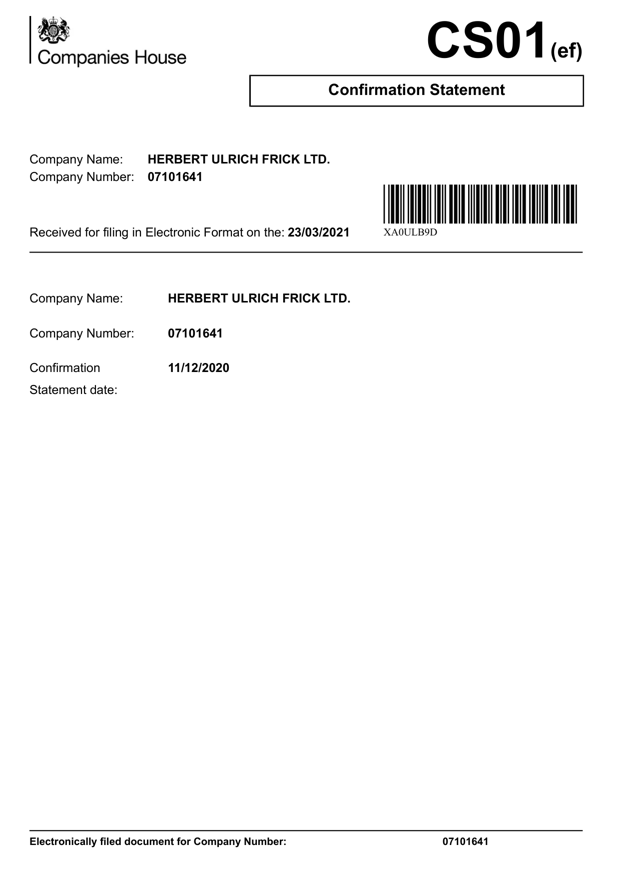
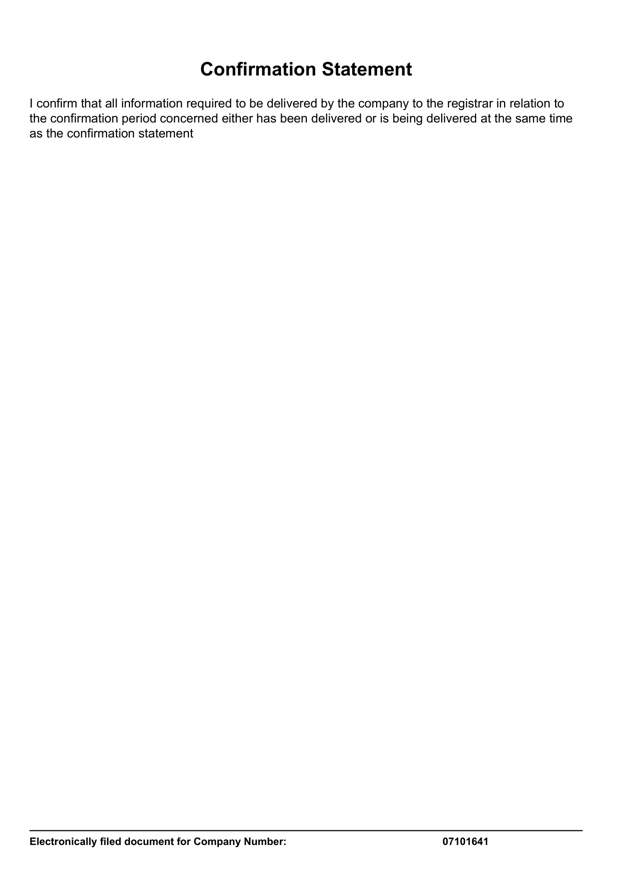
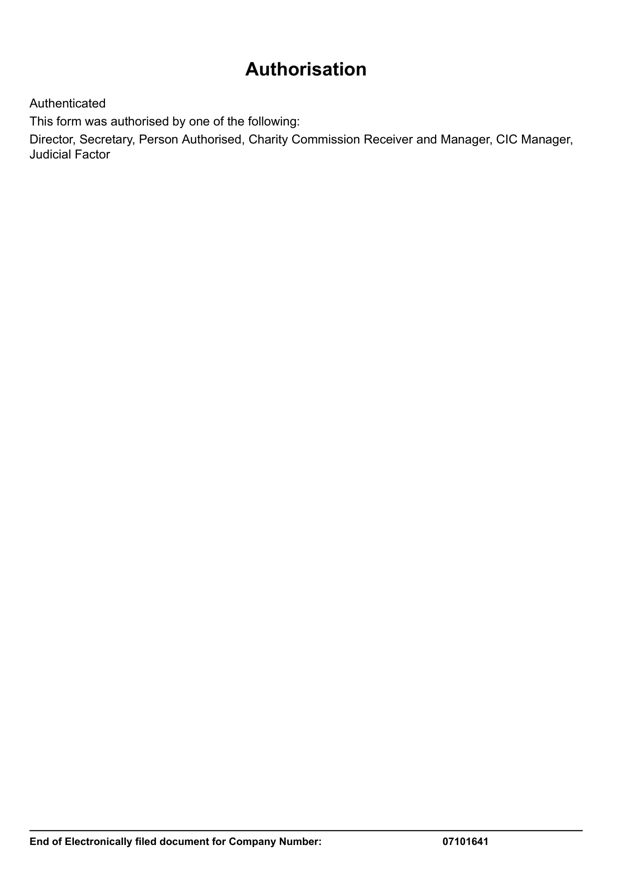

In [12]:
dataset[0]['messages']

In [13]:
dataset_filename = os.path.join(dataset_parent_path, f"{dataset_name.replace('/', '--').replace('.', '-')}.jsonl")
dataset.to_json(dataset_filename, lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

49994251

#### Upload file to S3

In [49]:
from sagemaker.s3 import S3Uploader

In [ ]:
data_s3_uri = f"s3://{sess.default_bucket()}/dataset"

uploaded_s3_uri = S3Uploader.upload(
    local_path=dataset_filename,
    desired_s3_uri=data_s3_uri
)
print(f"Uploaded {dataset_filename} to > {uploaded_s3_uri}")

## Fine-Tune LLMs using SageMaker `Estimator`/`ModelTrainer`

In [ ]:
import time
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace
from getpass import getpass
import yaml
from jinja2 import Template

In [ ]:
# Get Hugging Face token for model downloads (if needed)
hf_token = getpass()

### Training using `PyTorch` Estimator

**Training Using `PyTorch` Estimator**
Leverages the official PyTorch SageMaker container to run a custom training script using the Accelerate and DeepSpeed libraries. This option is ideal for users who want full control over the training pipeline 

---
**Observability**: SageMaker AI has [SageMaker MLflow](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html) which enables you to accelerate generative AI by making it easier to track experiments and monitor performance of models and AI applications using a single tool.

You can choose to include MLflow as a part of your training workflow to track your model fine-tuning metrics in realtime by simply specifying a **mlflow** tracking arn.

Optionally you can also report to : **tensorboard**, **wandb**.

In [ ]:
MLFLOW_TRACKING_SERVER_ARN = None # or "arn:aws:sagemaker:us-west-2:<account-id>:mlflow-tracking-server/<server-name>"

if MLFLOW_TRACKING_SERVER_ARN:
    reports_to = "mlflow"
else:
    reports_to = "tensorboard"

In [ ]:
job_name = 'meta-llama--Llama-3.2-11B-Instruct'
training_instance_type = "local_gpu"

In [ ]:
if MLFLOW_TRACKING_SERVER_ARN:
    training_env = {
        "MLFLOW_EXPERIMENT_NAME": f"exp-{job_name}",
        "MLFLOW_TAGS": '{"source.job": "sm-training-jobs", "source.type": "sft", "source.framework": "pytorch"}',
        "HF_TOKEN": hf_token,
        "MLFLOW_TRACKING_URI": MLFLOW_TRACKING_SERVER_ARN,
    }
else:
    training_env = {
        "HF_TOKEN": hf_token
    }

In [ ]:
pytorch_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:2.8.0-gpu-py312-cu129-ubuntu22.04-sagemaker"
print(f"Using image: {pytorch_image_uri}")

#### Training strategy: `PeFT/LoRA`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
    hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-peft-qlora.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")

#### Training strategy: `Spectrum`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
    hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-spectrum.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")

#### Training strategy: `Full-Finetuning`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
     hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-full.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")